# Zero-shot integration of CD138+ multiple myeloma plasmacytoma from 46 patients using scGPT

## Import scGPT and dependencies

In [2]:
from pathlib import Path
import warnings

import scanpy as sc
import scib
import numpy as np
import sys

sys.path.insert(0, "../")

import scgpt as scg
import matplotlib.pyplot as plt
import anndata

plt.style.context('default')
warnings.simplefilter("ignore", ResourceWarning)

model_dir = Path("/samurlab1/Joshua/scGPT_models/")

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scgpt/model/model.py:21: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scgpt/model/multiomic_model.py:19: UserWarning: flash_attn is not installed
  warnings.warn("flash_attn is not installed")


In [6]:
model_dir

PosixPath('/samurlab1/Joshua/scGPT_models')

## Set up evaluation function

We set up the evaluation function, we mainly compare the integration performance on avgBIO and avgBATCH. Refer to our manuscript for more details.

In [3]:
"""
Calculate the metrics for integration results
"""
def scib_eval(adata, batch_key, cell_type_key, embed_key):
    results = scib.metrics.metrics(
        adata,
        adata_int=adata,
        batch_key=batch_key,
        label_key=cell_type_key,
        embed=embed_key,
        isolated_labels_asw_=False,
        silhouette_=True,
        hvg_score_=False,
        graph_conn_=True,
        pcr_=True,
        isolated_labels_f1_=False,
        trajectory_=False,
        nmi_=True,  # use the clustering, bias to the best matching
        ari_=True,  # use the clustering, bias to the best matching
        cell_cycle_=False,
        kBET_=False,  # kBET return nan sometimes, need to examine
        ilisi_=False,
        clisi_=False,
    )
    result_dict = results[0].to_dict()
    
    # compute avgBIO metrics
    result_dict["avg_bio"] = np.mean(
        [
            result_dict["NMI_cluster/label"],
            result_dict["ARI_cluster/label"],
            result_dict["ASW_label"],
        ]
    )
    
    # compute avgBATCH metrics
    result_dict["avg_batch"] = np.mean(
        [
            result_dict["graph_conn"],
            result_dict["ASW_label/batch"],
        ]
    )
    
    result_dict = {k: v for k, v in result_dict.items() if not np.isnan(v)}
    
    return result_dict

## Prepare the datasets

Load the Lung-kim dataset (download it from [here](https://drive.google.com/file/d/1z_0vWYMhRuRiD1EyhuFtY9ReIR0msWaL/view?usp=sharing)), and we set the columns storing gene name columns, batch key and cell type key (optional, this is for evaluation).

In [4]:
smaple_data_path = '/samurlab1/Joshua/CD138mm.h5ad'
adata = sc.read_h5ad(smaple_data_path)

gene_col = "name"
cell_type_key = "ident"
batch_key = "sample"
N_HVG = 3000

In [5]:
adata.var


name
MIR1302-2HG  MIR1302-2HG
FAM138A          FAM138A
OR4F5              OR4F5
AL627309.1    AL627309.1
AL627309.3    AL627309.3
...                  ...
AC141272.1    AC141272.1
AC023491.2    AC023491.2
AC007325.1    AC007325.1
AC007325.4    AC007325.4
AC007325.2    AC007325.2

[36601 rows x 1 columns]

In [6]:
adata.obs

orig.ident  nCount_RNA  nFeature_RNA  sample  \
AAACCCATCATCAGTG-1_1          T21102     30562.0          1643  T21102   
AAACGAAAGGTAGTAT-1_1          T21102    121445.0          4485  T21102   
AAACGAAAGTGAGGTC-1_1          T21102     26117.0          1654  T21102   
AAACGAATCAGAGTTC-1_1          T21102     42926.0          2656  T21102   
AAACGCTAGGGCCCTT-1_1          T21102     30908.0          1891  T21102   
...                              ...         ...           ...     ...   
TTGTTGTCATTAAAGG-1_46  SeuratProject     12587.0          2386  T24162   
TTTATGCAGCATCCTA-1_46  SeuratProject      1105.0           472  T24162   
TTTATGCCACTACTTT-1_46  SeuratProject     52956.0          5345  T24162   
TTTCACAGTTTCCCAC-1_46  SeuratProject     17485.0          2840  T24162   
TTTCACATCACATTGG-1_46  SeuratProject      3169.0           967  T24162   

                      transloc   HMM        mut  progress  death  percent.mt  \
AAACCCATCATCAGTG-1_1      None  True  NRAS,BRAF     False  False    1.855245   
AAACGAAAGGTAGTAT-1_1      None  True  NRAS,BRAF     False  False    2.187822   
AAACGAAAGTGAGGTC-1_1      None  True  NRAS,BRAF     False  False    2.599839   
AAACGAATCAGAGTTC-1_1      None  True  NRAS,BRAF     False  False    3.412850   
AAACGCTAGGGCCCTT-1_1      None  True  NRAS,BRAF     False  False    1.805358   
...                        ...   ...        ...       ...    ...         ...   
TTGTTGTCATTAAAGG-1_46   del17p  True       TP53      True  False    4.536426   
TTTATGCAGCATCCTA-1_46   del17p  True       TP53      True  False    1.266968   
TTTATGCCACTACTTT-1_46   del17p  True       TP53      True  False    4.331898   
TTTCACAGTTTCCCAC-1_46   del17p  True       TP53      True  False    4.586789   
TTTCACATCACATTGG-1_46   del17p  True       TP53      True  False    0.883559   

                      RNA_snn_res.0.4 seurat_clusters ident  
AAACCCATCATCAGTG-1_1               12              12    12  
AAACGAAAGGTAGTAT-1_1               12              12    12  
AAACGAAAGTGAGGTC-1_1               12              12    12  
AAACGAATCAGAGTTC-1_1               12              12    12  
AAACGCTAGGGCCCTT-1_1               12              12    12  
...                               ...             ...   ...  
TTGTTGTCATTAAAGG-1_46              23              23    23  
TTTATGCAGCATCCTA-1_46              11              11    11  
TTTATGCCACTACTTT-1_46              28              28    28  
TTTCACAGTTTCCCAC-1_46              28              28    28  
TTTCACATCACATTGG-1_46              28              28    28  

[105660 rows x 13 columns]

Remove unannotated cells:

In [7]:
celltype_id_labels = adata.obs[cell_type_key].astype("category").cat.codes.values
adata = adata[celltype_id_labels >= 0]

Make a copy of the dataset

In [8]:
org_adata = adata.copy()

Preprocess the dataset and select `N_HVG` highly variable genes for downstream analysis.

In [9]:
# highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:151: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": "seurat_v3"}


In [13]:
from scipy.sparse import csr_matrix, csc_matrix

# Check if adata.X is sparse (either csr_matrix or csc_matrix) and convert to dense
if isinstance(adata.X, (csr_matrix, csc_matrix)):
    adata.X = adata.X.toarray()  # Convert sparse matrix to dense array
    

## Generate the cell embeddings

Now we will generate the cell embeddings for the dataset using `embed_data` function. `embed_data` calculates the cell embedding for each cell with the given scGPT model. The extracted embedding is stored in the `X_scGPT` field of `obsm` in AnnData.

In [14]:
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=8,
)
# attach the cell embedding to the original adata

scGPT - INFO - match 2636/3000 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 13208/13208 [02:39<00:00, 82.99it/s] 
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scgpt/tasks/cell_emb.py:279: ImplicitModificationWarning: Setting element `.obsm['X_scGPT']` of view, initializing view as actual.
  adata.obsm["X_scGPT"] = cell_embeddings


## Visualize the integration performance

UMAP of scGPT embedding colored by cell type:

In [15]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


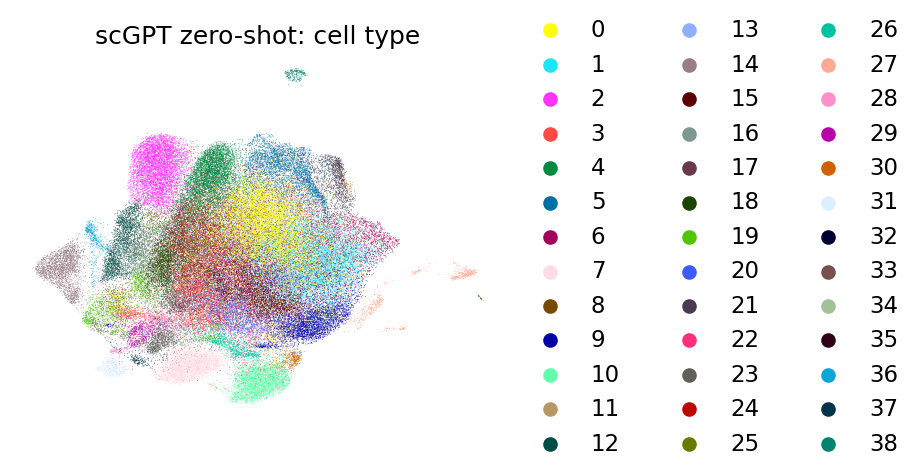

In [16]:
sc.pl.umap(embed_adata, 
           color=[cell_type_key], 
           frameon=False, 
           wspace=0.4, 
           title=["scGPT zero-shot: cell type"])

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


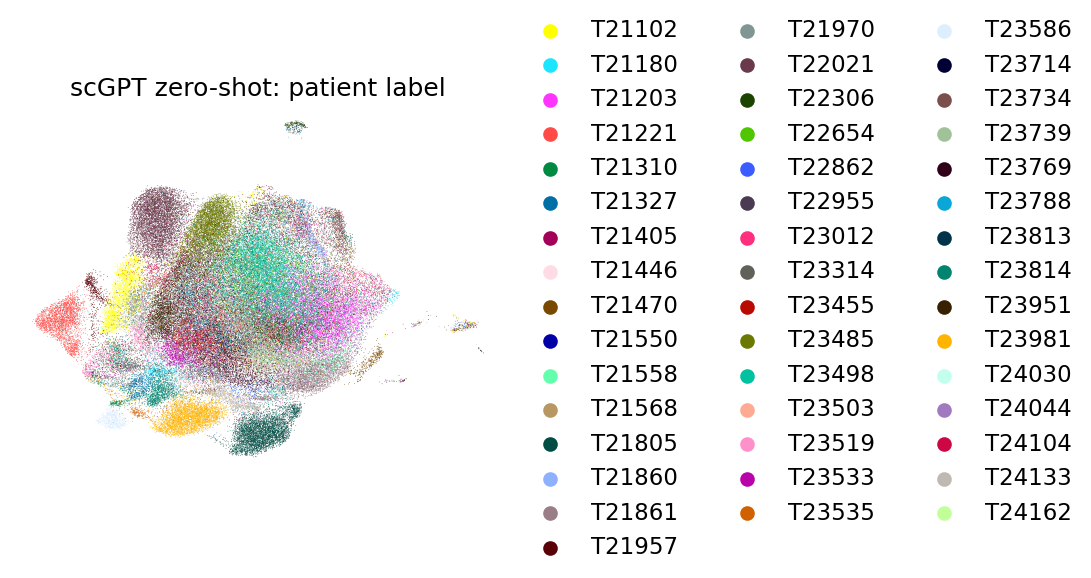

In [17]:
sc.pl.umap(embed_adata, 
           color=["sample"], 
           frameon=False, 
           wspace=0.4, 
           title=["scGPT zero-shot: patient label"])

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


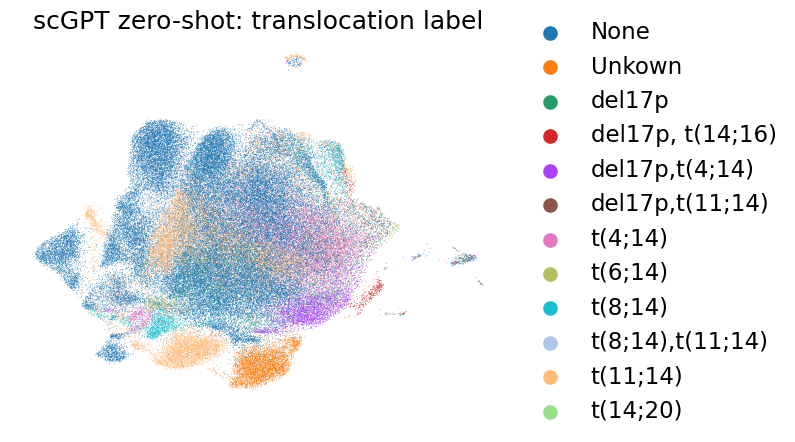

In [18]:
sc.pl.umap(embed_adata, 
           color=["transloc"], 
           frameon=False, 
           wspace=0.4, 
           title=["scGPT zero-shot: translocation label"])

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


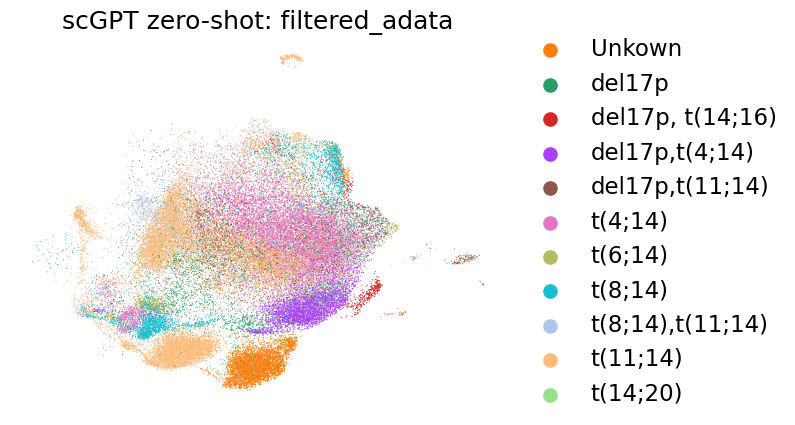

In [37]:
# this is translocation data without non-translocation patients
exclude = "None"

filtered_adata = embed_adata[embed_adata.obs["transloc"] != exclude]

sc.pl.umap(
    filtered_adata,
    color = ["transloc"],
    frameon=False,
    wspace=0.4,
    title = ["scGPT zero-shot: filtered_adata"]
)

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


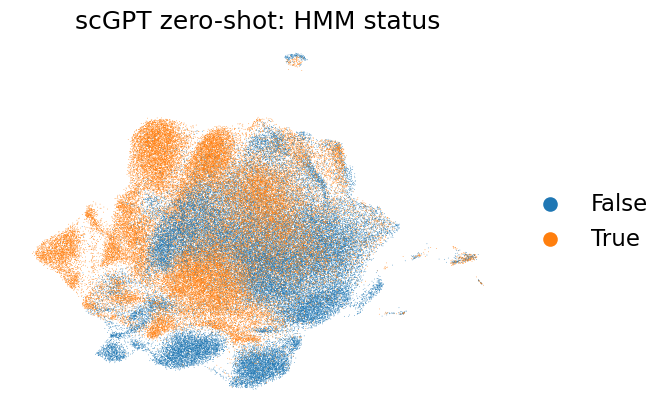

In [36]:
# Convert the "HMM" column to a categorical type
embed_adata.obs["HMM"] = embed_adata.obs["HMM"].astype("category")

sc.pl.umap(embed_adata, 
           color=["HMM"], 
           frameon=False, 
           wspace=0.4, 
           title=["scGPT zero-shot: HMM status"])

## Evaluate the integration performance

In [23]:
s_genes = ['MCM5', 'MCM6', 'MCM7', 'CCNA2', 'CCNB1', 'CCNB2', 'CDK1', 'CDK2', 'GINS1', 'GINS2', 'GINS3', 'GINS4', 'RFC4', 'RRM2', 'TYMS', 'UBE2C', 'EXOSC3', 'CDC6']
g2m_genes = ['ANLN', 'BUB1', 'BUB1B', 'CCNB1', 'CCNB2', 'CDC20', 'CDC25C', 'FZR1', 'KIF20A', 'KIF23', 'MAD2L1', 'TACC3', 'TPX2', 'UBE2C']

cell_cycle_genes = s_genes + g2m_genes
scib_result_dict = scib_eval(
    embed_adata,
    batch_key= "sample",
    cell_type_key=cell_type_key,
    embed_key="X_scGPT"
)

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph connectivity...


/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_c

In [24]:
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

AvgBIO: 0.5552
AvgBATCH: 0.9056


## Comparison with HVG+PCs

We compute the HVG and PCs based on the dataset, this will serve as a baseline for the integration performance.

In [25]:
adata = org_adata.copy()
sc.pp.highly_variable_genes(adata, n_top_genes=N_HVG, flavor='seurat_v3')
adata = adata[:, adata.var['highly_variable']]
sc.pp.pca(adata, n_comps=40)
sc.pp.neighbors(adata, use_rep="X_pca")

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca


UMAP of PCs colored by cell types and batch labels:

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


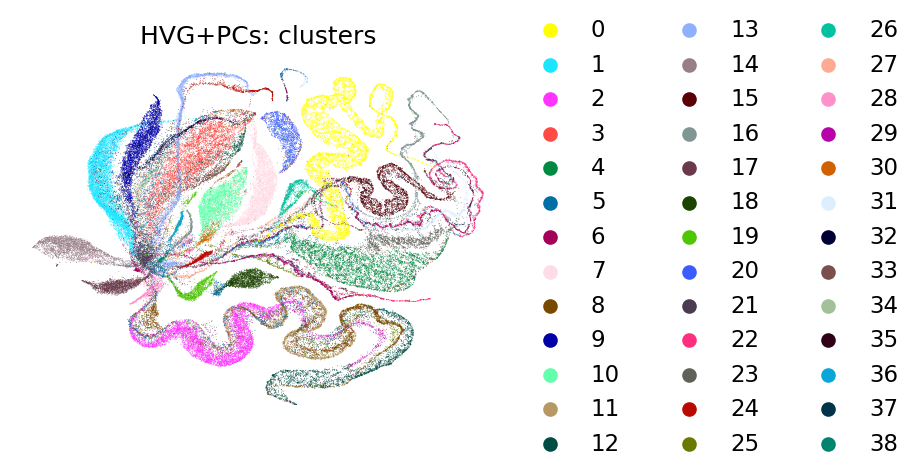

In [30]:
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)


/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


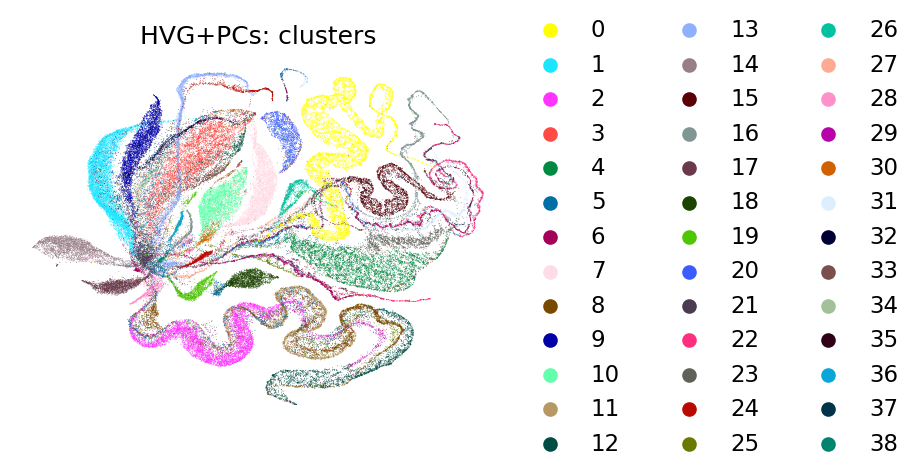

In [31]:
sc.pl.umap(adata, 
           color=[cell_type_key], 
           frameon=False, 
           wspace=0.4, 
           title=["HVG+PCs: clusters"])

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


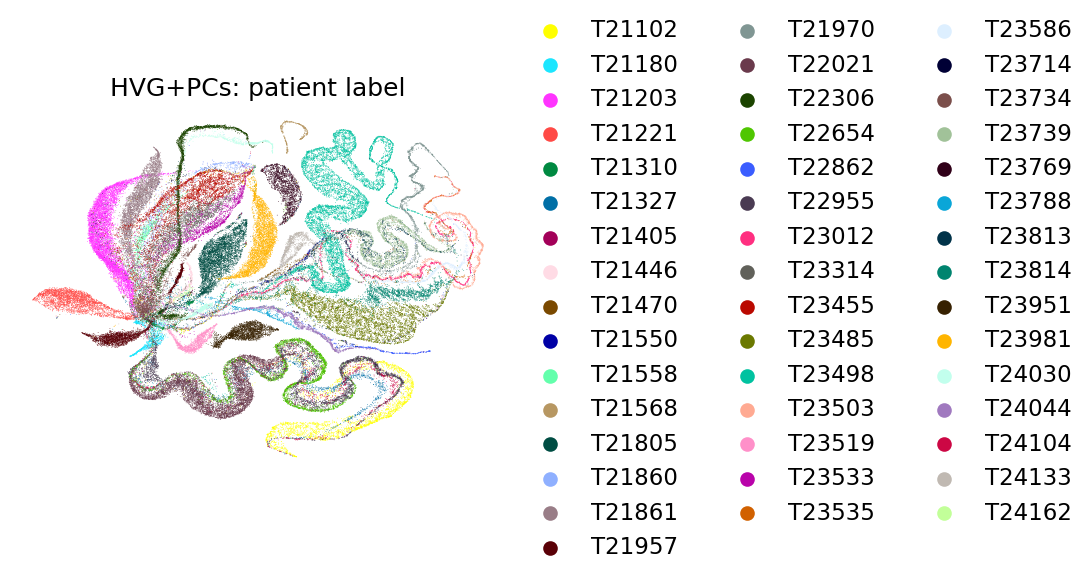

In [29]:
sc.pl.umap(adata, 
           color=[batch_key], 
           frameon=False, 
           wspace=0.4, 
           title=["HVG+PCs: patient label"])

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


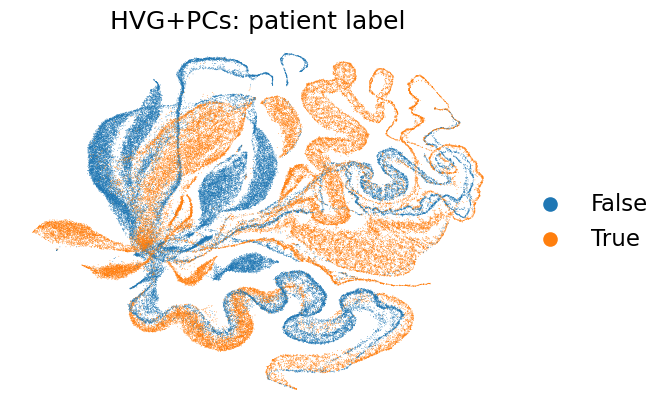

In [33]:
# Convert the "HMM" column to a categorical type
adata.obs["HMM"] = embed_adata.obs["HMM"].astype("category")
sc.pl.umap(adata, 
           color=["HMM"], 
           frameon=False, 
           wspace=0.4, 
           title=["HVG+PCs: patient label"])

In [34]:
scib_result_dict = scib_eval(
    adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_pca",
)

/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scib/metrics/metrics.py:293: DeprecationWarning: Call to deprecated function (or staticmethod) opt_louvain.
  res_max, nmi_max, nmi_all = opt_louvain(


NMI...
ARI...
Silhouette score...
PC regression...


/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


Graph connectivity...


/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
/samurlab1/Joshua/joshMiniforge3/envs/scgpt_aries2/lib/python3.10/site-packages/scib/metrics/graph_connectivity.py:56: FutureWarning: pandas.value_c

In [35]:
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

AvgBIO: 0.5532
AvgBATCH: 0.7467


## Appendix: Zero-shot integration on COVID-19 dataset and MS dataset

### COVID-19 dataset

The dataset can be accessed form [here](https://drive.google.com/file/d/1eD9LbxNJ35YUde3VtdVcjkwm-f4iyJ6x/view?usp=drive_link).

In [10]:
# load dataset
adata = sc.read_h5ad('../../data/covid_subsampled.h5ad')
gene_col = "name"
cell_type_key = "celltype"
batch_key = "str_batch"
embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '../../data/covid_subsampled.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

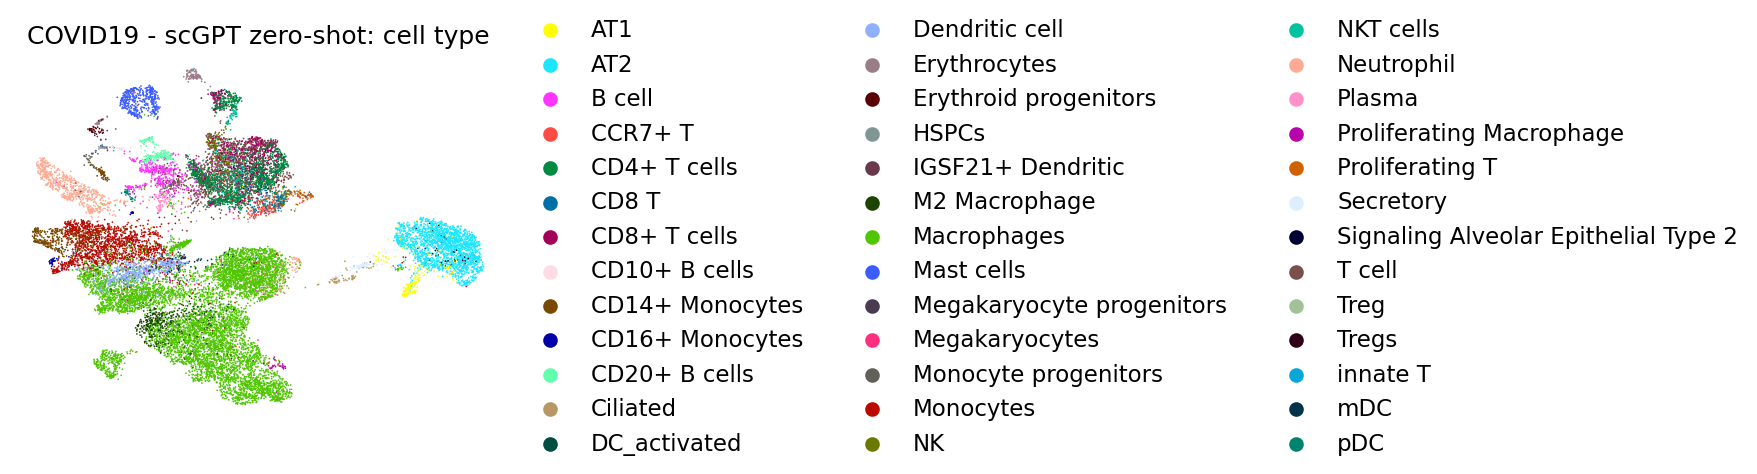

In [34]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=[cell_type_key], 
           frameon=False, 
           title=["COVID19 - scGPT zero-shot: cell type"])

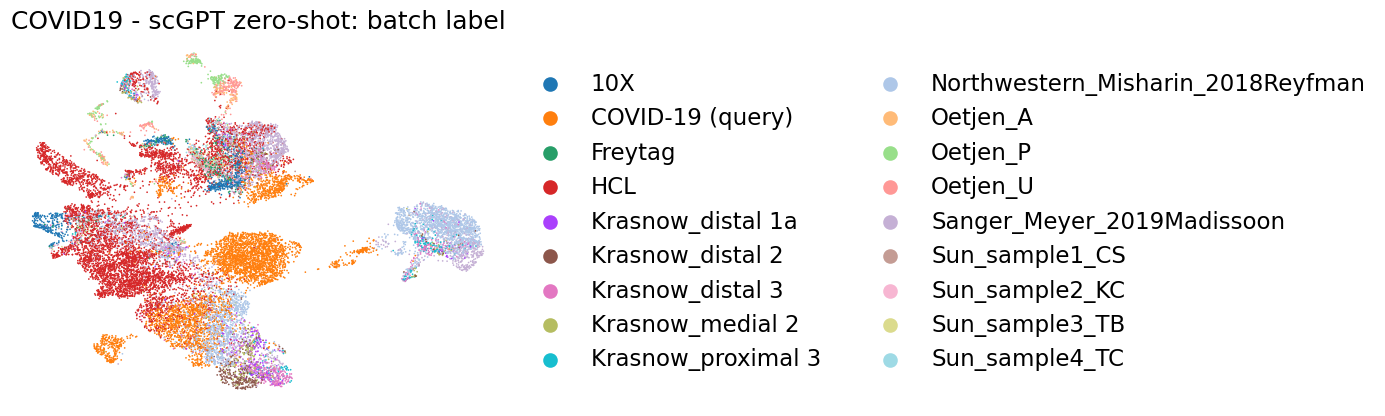

In [35]:
sc.pl.umap(embed_adata, 
           color=[batch_key], 
           frameon=False, 
           title=["COVID19 - scGPT zero-shot: batch label"])

In [36]:
scib_result_dict = scib_eval(
    embed_adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_scGPT",
)
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

NMI...
ARI...
Silhouette score...
PC regression...
Variance contribution increased after integration!
Setting PCR comparison score to 0.
Graph connectivity...
AvgBIO: 0.4888
AvgBATCH: 0.8741


## Comparison with HVG+PCs

In [19]:
sc.pp.pca(adata, n_comps=40)
sc.pp.neighbors(adata, use_rep="X_pca")

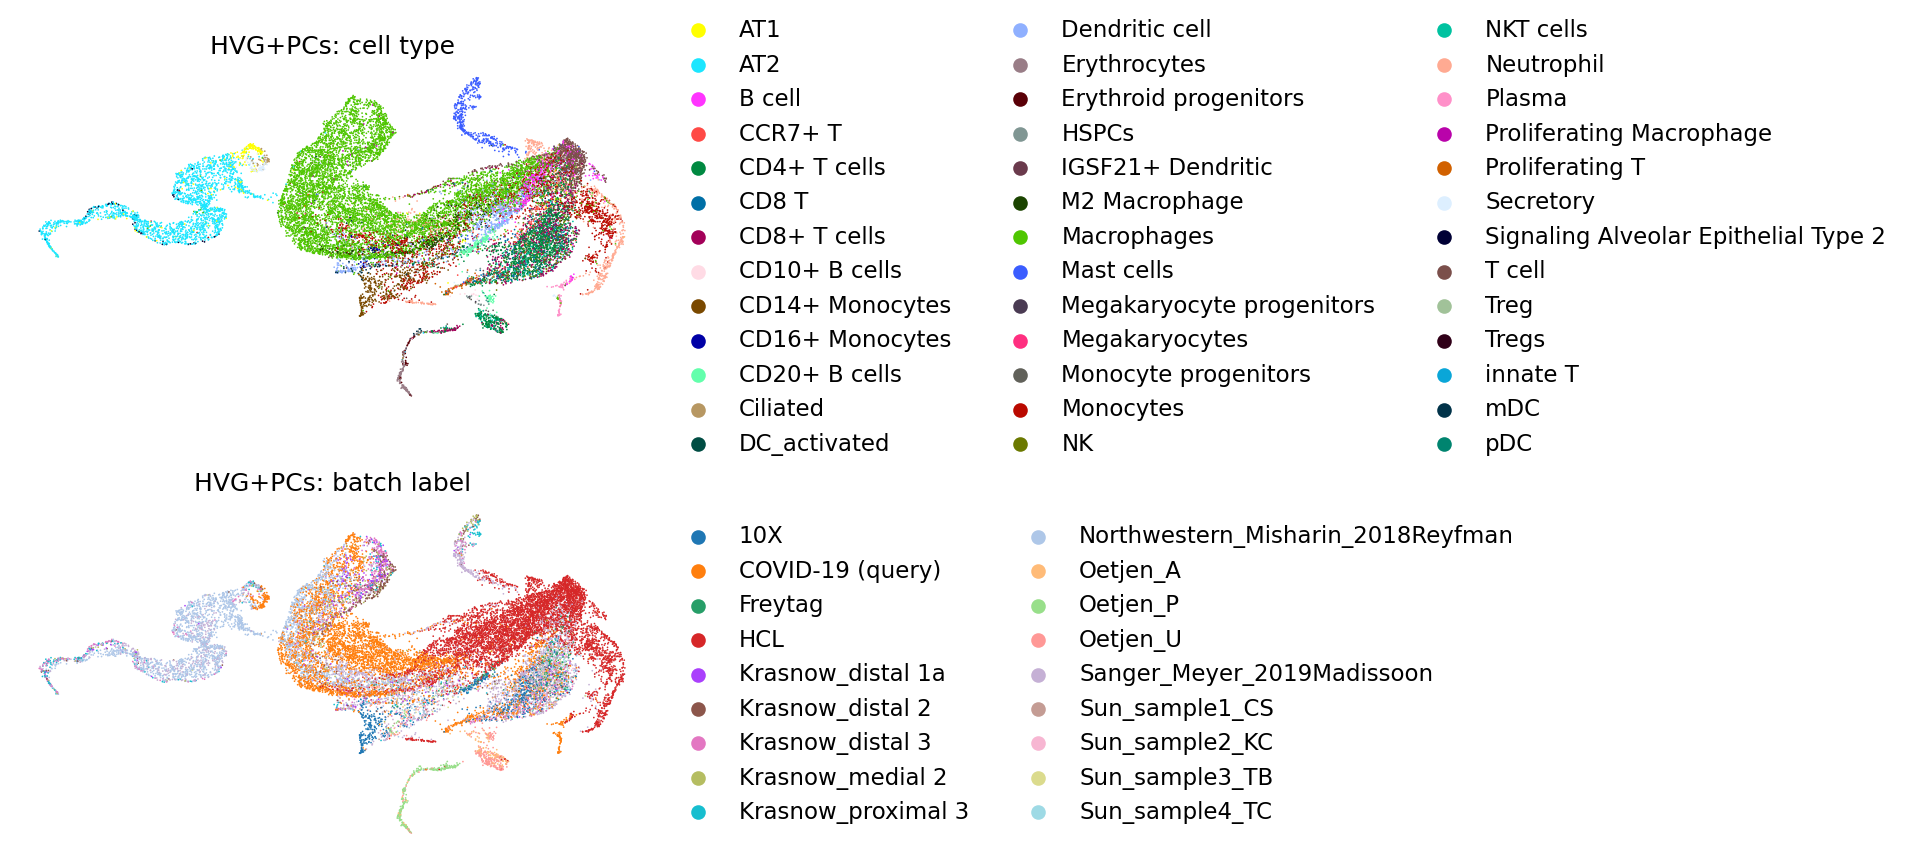

In [20]:
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=[cell_type_key, batch_key],
    frameon=False,
    wspace=0.4,
    title=["HVG+PCs: cell type", "HVG+PCs: batch label"],
    ncols=1,
)

In [21]:
scib_result_dict = scib_eval(
    adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_pca",
)
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
AvgBIO: 0.3804
AvgBATCH: 0.6743


### MS dataset

The dataset can be accessed form [here](https://drive.google.com/drive/folders/1Qd42YNabzyr2pWt9xoY4cVMTAxsNBt4v?usp=sharing). As this is a preprocessed dataset, we will need to concatenate the training/test datasets together first.

In [22]:
gene_col = "gene_name"
cell_type_key = "celltype"
batch_key = "Sample Characteristic[individual]"

train_data = sc.read_h5ad('../../data/ms/c_data.h5ad')
test_data = sc.read_h5ad('../../data/ms/filtered_ms_adata.h5ad')
test_data.var.index = test_data.var[gene_col]
adata = anndata.concat([train_data, test_data], join='outer')
adata.var[gene_col] = adata.var.index

embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
)

/h/haotian/.conda/envs/scgpt/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


scGPT - INFO - match 2808/3000 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 333/333 [00:12<00:00, 26.59it/s]


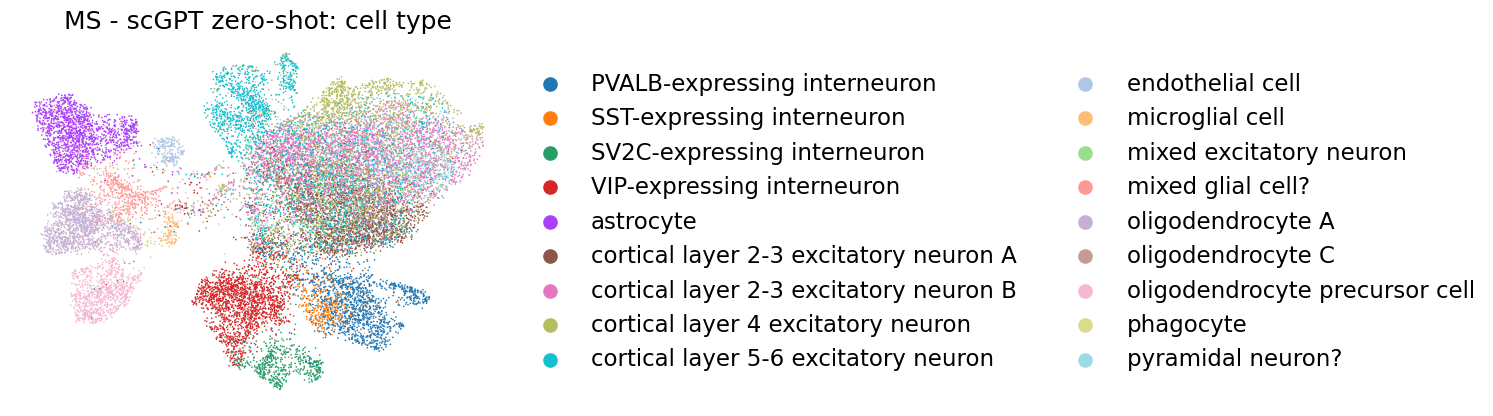

In [23]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=[cell_type_key], 
           frameon=False, 
           title=["MS - scGPT zero-shot: cell type"])

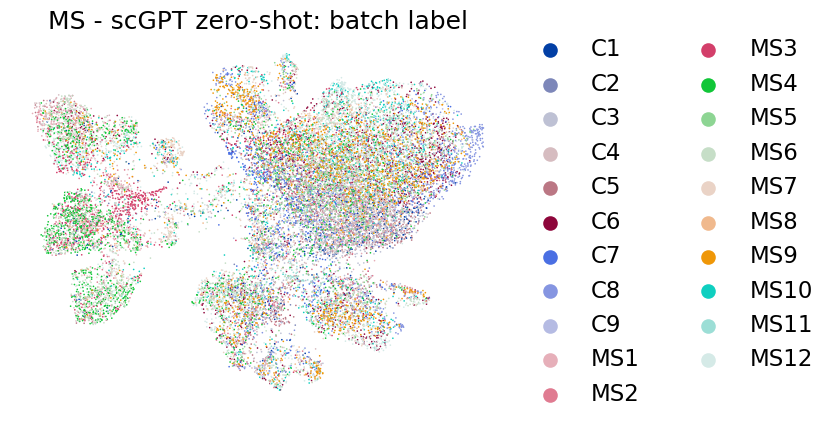

In [24]:
sc.pp.neighbors(embed_adata, use_rep="X_scGPT")
sc.tl.umap(embed_adata)
sc.pl.umap(embed_adata, 
           color=[batch_key], 
           frameon=False, 
           title=["MS - scGPT zero-shot: batch label"])

In [25]:
scib_result_dict = scib_eval(
    embed_adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_scGPT",
)
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
AvgBIO: 0.4525
AvgBATCH: 0.9129


## Comparison with HVG+PCs

In [26]:
sc.pp.pca(adata, n_comps=40)
sc.pp.neighbors(adata, use_rep="X_pca")

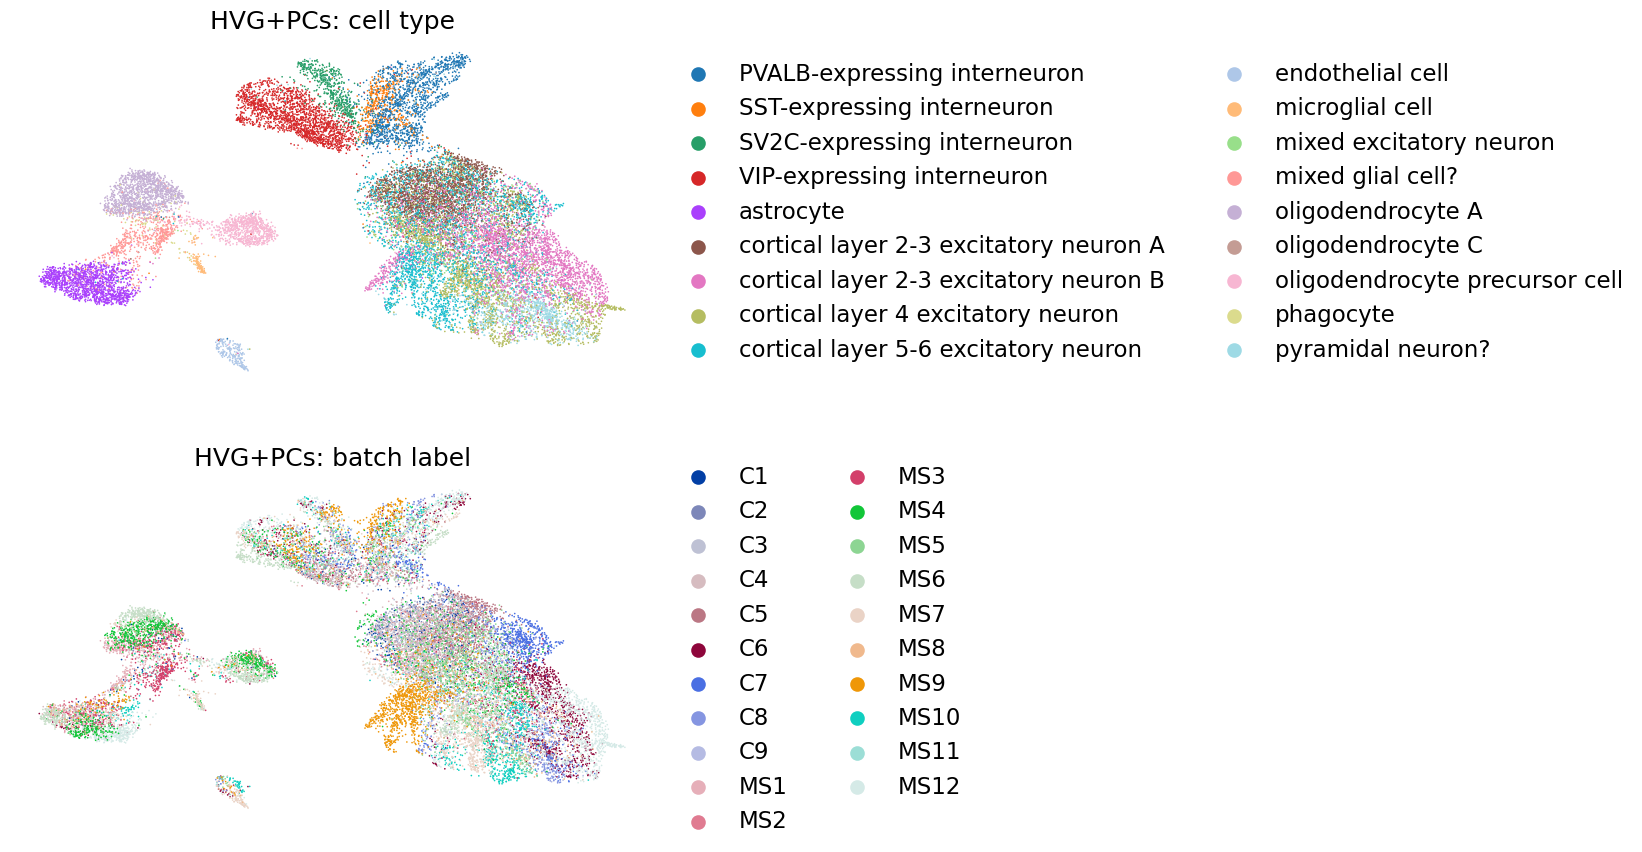

In [27]:
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.umap(adata)
sc.pl.umap(
    adata,
    color=[cell_type_key, batch_key],
    frameon=False,
    wspace=0.4,
    title=["HVG+PCs: cell type", "HVG+PCs: batch label"],
    ncols=1,
)

In [28]:
scib_result_dict = scib_eval(
    adata,
    batch_key=batch_key,
    cell_type_key=cell_type_key,
    embed_key="X_pca",
)
print("AvgBIO: {:.4f}".format(scib_result_dict["avg_bio"]))
print("AvgBATCH: {:.4f}".format(scib_result_dict["avg_batch"]))

NMI...
ARI...
Silhouette score...
PC regression...
Graph connectivity...
AvgBIO: 0.5062
AvgBATCH: 0.9075
